In [1]:
import neural_priors

In [2]:
from neural_priors.utils.plotting import plot_prf_predictions
from neural_priors.utils.data import Subject, get_all_subject_ids, get_all_behavioral_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
from scipy import stats, odr
from braincoder.models import LogGaussianPRF, GaussianPRF

In [3]:
plt.rcParams['legend.frameon'] = False
np.set_printoptions(linewidth=140)
pd.set_option('display.width', 170) # 80
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 70)

In [4]:
bids_folder = '../../ds-neuralpriors'

2024-05-23 22:11:14.959212: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')


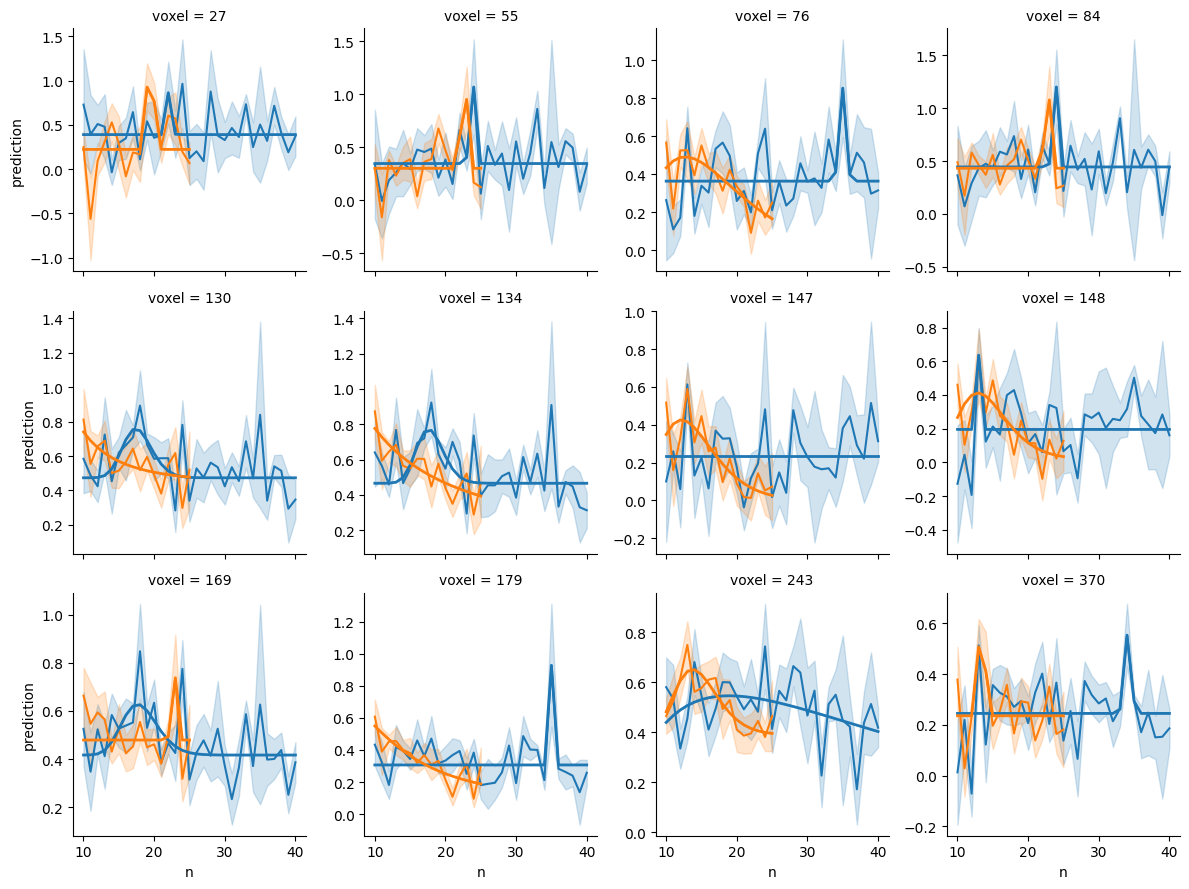

In [5]:
plot_prf_predictions('10', bids_folder=bids_folder)

In [6]:
ll ../../ds-neuralpriors/sourcedata/behavior/

total 0
drwx------@ 5 apc  staff  160 Apr 30 14:09 sub-01/
drwx------@ 5 apc  staff  160 Apr 26 12:49 sub-02/
drwx------  5 apc  staff  160 Apr 29 16:43 sub-03/
drwx------  5 apc  staff  160 Apr 30 14:14 sub-04/
drwx------@ 5 apc  staff  160 Apr 30 14:14 sub-05/
drwx------@ 4 apc  staff  128 May 15 11:18 sub-06/
drwx------@ 4 apc  staff  128 May 15 11:18 sub-07/
drwx------@ 4 apc  staff  128 May 15 11:18 sub-08/
drwx------  5 apc  staff  160 May 15 11:18 sub-09/
drwx------  5 apc  staff  160 May 15 11:17 sub-10/
drwx------  3 apc  staff   96 May 15 11:18 sub-11/
drwx------  4 apc  staff  128 May 15 11:18 sub-12/
drwx------  4 apc  staff  128 May 15 11:18 sub-13/
drwx------  4 apc  staff  128 May 15 11:18 sub-14/
drwx------  4 apc  staff  128 May 15 11:18 sub-15/
drwx------  4 apc  staff  128 May 15 11:18 sub-16/
drwx------  4 apc  staff  128 May 15 11:18 sub-17/
drwx------  4 apc  staff  128 May 15 11:18 sub-18/
drwx------  4 apc  staff  128 May 15 11:18 sub-19/
drwx------  4 apc  staf

In [7]:
get_all_subject_ids()

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'])

In [8]:
behavior = get_all_behavioral_data(bids_folder=bids_folder) #, subjects=[f'{i}'.rjust(2,'0') for i in range(1,23)])

In [9]:
behavior

onset  phase  response  nr_frames     n  jitter  start_marker_position  response_time   onset_abs  duration   range  error  \
subject session run trial_nr                                                                                                                                    
01      1       1   1          68.826307      5       NaN       30.0  11.0     6.0                   24.0            NaN   76.378611  0.500457  narrow    NaN   
                    2          76.016292      5      19.0       31.0  23.0     4.0                   14.0       1.317963   83.568595  0.517188  narrow   -4.0   
                    3          87.026471      5      25.0       30.0  23.0     6.0                   11.0       0.834244   94.578775  0.500469  narrow    2.0   
                    4          97.085656      5      24.0       30.0  22.0     5.0                   22.0       1.701381  104.637959  0.500559  narrow    2.0   
                    5         106.744768      5      17.0       31.0  21.0     5.0                   22.0       2.018881  114.297072  0.517009  narrow   -4.0   
...                                  ...    ...       ...        ...   ...     ...                    ...            ...         ...       ...     ...    ...   
24      2       8   26        279.957096      5      24.0       31.0  13.0     5.0                   25.0       1.385050  283.025374  0.517056    wide   11.0   
                    27        290.900569      5      15.0       30.0  11.0     6.0                   15.0       1.317862  293.968847  0.500460    wide    4.0   
                    28        302.160998      5      27.0       30.0  12.0     6.0                   16.0       1.083384  305.229276  0.500410    wide   15.0   
                    29        312.203573      5      23.0       30.0  39.0     6.0                   14.0       1.468224  315.271851  0.500535    wide  -16.0   
                    30        321.662398      5      25.0       30.0  21.0     5.0                   31.0       1.184674  324.730676  0.500440    wide    4.0   

                              abs_error  squared_error  
subject session run trial_nr                            
01      1       1   1               NaN            NaN  
                    2               4.0           16.0  
                    3               2.0            4.0  
                    4               2.0            4.0  
                    5               4.0           16.0  
...                                 ...            ...  
24      2       8   26             11.0          121.0  
                    27              4.0           16.0  
                    28             15.0          225.0  
                    29             16.0          256.0  
                    30              4.0           16.0  

[11040 rows x 14 columns]

In [10]:
from tqdm.contrib.itertools import product

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
load_data_via_tsv = True

if load_data_via_tsv:
    df = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t',
                    index_col=[0, 1, 2, 3, 4, 5,],
                    dtype={'subject':str})
    df.columns.name = 'parameter'
    df.index.set_names('voxel', level=-1, inplace=True)
else:
    df = []
    keys = []
    subjects = [f'{subject:02d}' for subject in range(1, 11)]
    #subjects.pop(subjects.index('11'))
    #subjects.pop(subjects.index('16'))

    for subject, range_n, session, smoothed, gaussian in product(subjects, ['wide', 'narrow', None, 'wide2'], [None], [True, False], [False, True]):
    # for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None], [None], [True, False]):
        sub = Subject(subject, bids_folder)
        sub_df = sub.get_prf_parameters_volume(session=session, cross_validated=False, roi='NPCr', smoothed=smoothed, range_n=range_n, gaussian=gaussian)
        if gaussian:
            sub_df = sub_df.rename(columns={'mu':'mode', 'sd':'width'})
        else:
            sub_df = sub_df.rename(columns={'fwhm':'width'})
        df.append(sub_df)
        keys.append((subject,
                    range_n if range_n is not None else 'both', session if session is not None else 'both',
                    'smoothed' if smoothed else 'unsmoothed',
                    'gaussian' if gaussian else 'lognormal'))

    df = pd.concat(df, keys=keys, names=['subject', 'range_n', 'session', 'smoothed', 'model'])
    df.to_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t')

df = df.unstack(['range_n', 'model', ]).reorder_levels(axis='columns', order=['model', 'parameter', 'range_n'])
df = df.sort_index(axis=1, level=['model'], sort_remaining=False)

In [12]:
df

model                              gaussian                                                                                                                             \
parameter                              mode                                      width                               amplitude                                baseline   
range_n                                wide     narrow       both      wide2      wide    narrow      both     wide2      wide    narrow      both     wide2      wide   
subject session smoothed   voxel                                                                                                                                         
01      both    smoothed   0       1.000000   1.000000   1.000000   1.000000  0.930751  0.930751  0.930751  0.930751  0.000100  0.000100  0.000100  0.000100 -0.083484   
                           1      33.824696   1.000000   1.000000  29.212122  0.691652  0.930751  0.930751  0.424628  0.748900  0.000100  0.000100  0.000100 -0.531616   
                           2       1.000000  29.212122   1.000000   1.000000  0.930751  0.424628  0.930751  0.930751  0.000100  0.000100  0.000100  0.000100 -0.495237   
                           3       1.000000  29.212122   1.000000   1.000000  0.930751  0.424628  0.930751  0.930751  0.000100  0.000100  0.000100  0.000100 -0.296557   
                           4      11.837559   1.000000   1.000000  11.841605  0.780824  0.930751  0.930751  0.820671  0.960968  0.000100  0.000100  1.066749 -0.108620   
...                                     ...        ...        ...        ...       ...       ...       ...       ...       ...       ...       ...       ...       ...   
10      both    unsmoothed 738     1.000000  29.212122  44.060608   1.000000  0.930751  0.424628  0.424628  0.930751  0.000100  0.000100  0.000100  0.000100  0.095626   
                           739     1.000000  29.212122  21.219534   1.000000  0.930751  0.424628  3.183350  0.930751  0.000100  0.000100  0.271916  0.000100  0.309958   
                           740     1.000000   1.000000   1.000000   1.000000  0.930751  0.930751  0.930751  0.930751  0.000100  0.000100  0.000100  0.000100  0.176200   
                           741    22.589546  19.769102  20.883620  29.212122  2.169051  2.167511  1.934027  0.424628  0.343327  0.310813  0.278980  0.000100  0.360307   
                           742     1.000000  29.212122   1.000000   1.000000  0.930751  0.424628  0.930751  0.930751  0.000100  0.000100  0.000100  0.000100  0.315070   

model                                                                                                                                                           \
parameter                                                                 r2                                                cvr2                                 
range_n                             narrow      both     wide2          wide        narrow          both         wide2      wide    narrow      both     wide2   
subject session smoothed   voxel                                                                                                                                 
01      both    smoothed   0     -0.066864 -0.075230 -0.137222  6.556511e-07  5.960465e-07  7.748604e-07  6.556511e-07 -0.012844 -0.014613 -0.012049 -0.056759   
                           1     -0.479922 -0.487690 -0.571957  2.112496e-02  5.960465e-07  3.576279e-07  0.000000e+00 -0.077270 -0.014289 -0.011270 -0.033588   
                           2     -0.459087 -0.477198 -0.570179  5.960465e-07  4.768372e-07  3.576279e-07  7.748604e-07 -0.015736 -0.023125 -0.014602 -0.058087   
                           3     -0.246659 -0.271674 -0.336445  8.940697e-07  8.344650e-07  1.192093e-06  7.748604e-07 -0.012943 -0.020752 -0.018528 -0.048616   
                           4     -0.084071 -0.065042 -0.199106  2.714705e-02  2.384186e-07  2.980232e-07  5.054170e-02 -0.059544 -0.010724 -0.008848 -0.1

Text(0.5, 1.0, 'cvr2, narrow')

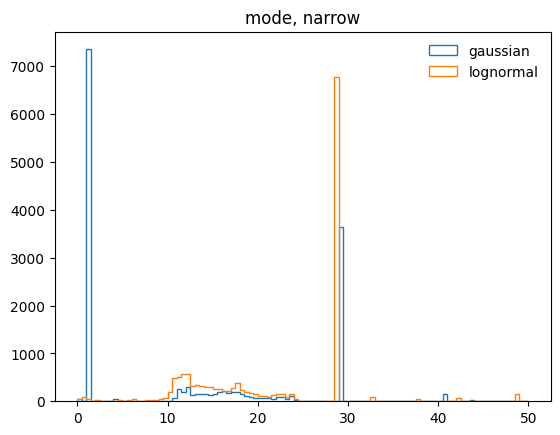

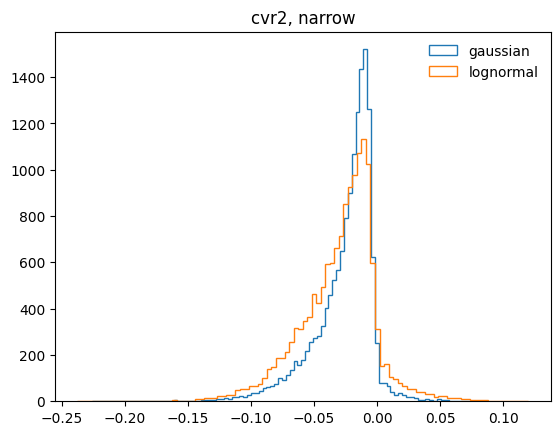

In [13]:
plt.hist( df['gaussian', 'mode', 'narrow'], histtype='step', bins=100, label='gaussian');
plt.hist( df['lognormal', 'mode', 'narrow'], histtype='step', bins=100, label='lognormal');
plt.legend();
plt.title('mode, narrow')
plt.figure()
plt.hist( df['gaussian', 'cvr2', 'narrow'], histtype='step', bins=100, label='gaussian');
plt.hist( df['lognormal', 'cvr2', 'narrow'], histtype='step', bins=100, label='lognormal');
plt.legend();
plt.title('cvr2, narrow')

In [14]:
df.xs(key=('cvr2','wide'), axis=1, level=('parameter','range_n') )

model                             gaussian  lognormal
subject session smoothed   voxel                     
01      both    smoothed   0     -0.012844  -0.010083
                           1     -0.077270  -0.077511
                           2     -0.015736  -0.078256
                           3     -0.012943  -0.083966
                           4     -0.059544  -0.054707
...                                    ...        ...
10      both    unsmoothed 738   -0.027534  -0.027534
                           739   -0.013086  -0.039796
                           740   -0.018214  -0.065107
                           741   -0.006784  -0.025200
                           742   -0.009731  -0.021204

[15020 rows x 2 columns]

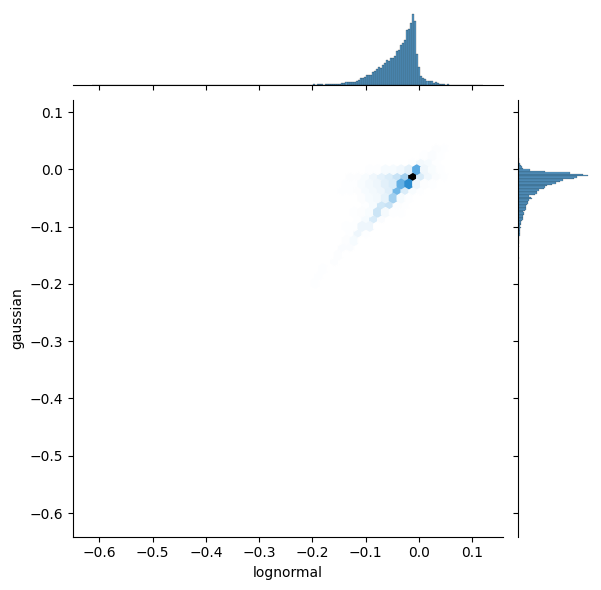

In [15]:
sns.jointplot(data=df.xs(key=('cvr2','wide'), axis=1, level=('parameter','range_n') ), x='lognormal', y='gaussian', kind='hex')

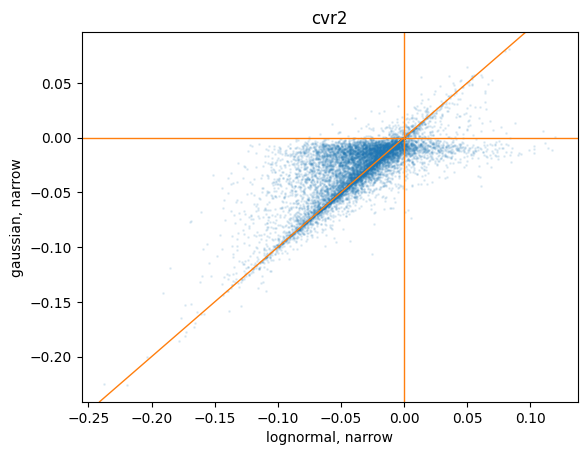

In [16]:
#sns.scatterplot(data=df.xs('cvr2', axis=1, level='parameter'), x='lognormal', y='gaussian', hue='range_n')
plt.scatter(df['lognormal', 'cvr2', 'narrow'], df['gaussian', 'cvr2', 'narrow'], s=1, alpha=.1);
plt.xlabel('lognormal, narrow'); plt.ylabel('gaussian, narrow')
plt.title('cvr2')
plt.axline((0,0), slope=1, c='C1', lw=1)
plt.axhline(0, c='C1', lw=1)
plt.axvline(0, c='C1', lw=1)

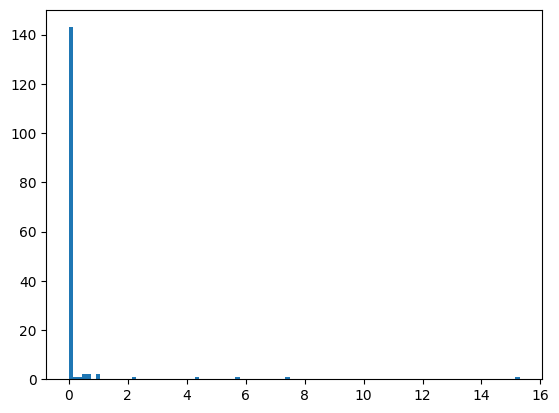

In [30]:
# doing good with lognormal but not with gaussian 
# and have (lognormal) mode in the range
mask = (df[('lognormal', 'cvr2', 'narrow')] > 0.01) & (df[('gaussian', 'cvr2', 'narrow')] < 0.0)
mask &= (df[('lognormal', 'mode', 'narrow')] >= 12 ) & (df[('lognormal', 'mode', 'narrow')] <= 23 )
plt.hist( df[mask][('gaussian','amplitude','narrow')], bins=100);

In [31]:
df[mask][('gaussian','amplitude','narrow')].shape

(156,)

In [32]:
np.mean( df[mask][('gaussian','amplitude','narrow')].values <= 0.001 )

0.9166666666666666

In [33]:
df[mask]

model                              gaussian                                                                                                                        \
parameter                              mode                                   width                               amplitude                              baseline   
range_n                                wide narrow       both      wide2       wide    narrow      both     wide2      wide  narrow      both     wide2      wide   
subject session smoothed   voxel                                                                                                                                    
01      both    smoothed   303     1.000000    1.0   1.000000   1.000000   0.930751  0.930751  0.930751  0.930751  0.000100  0.0001  0.000100  0.000100  0.795876   
                           367     1.000000    1.0   1.000000   1.000000   0.930751  0.930751  0.930751  0.930751  0.000100  0.0001  0.000100  0.000100  0.571752   
                           486    19.341350    1.0  14.697037  19.331076   0.313931  0.930751  4.314126  0.310130  0.490955  0.0001  0.155380  0.464767  0.453956   
                           527    15.110373    1.0  19.526070  29.212122   0.653717  0.930751  0.327839  0.424628  0.210774  0.0001  0.486298  0.000100  0.598468   
                           588    20.177172    1.0   1.000000  29.212122  26.813139  0.930751  0.930751  0.424628  0.747958  0.0001  0.000100  0.000100 -0.523219   
...                                     ...    ...        ...        ...        ...       ...       ...       ...       ...     ...       ...       ...       ...   
10      both    smoothed   76     34.964718    1.0   1.000000  17.860683   0.448074  0.930751  0.930751  0.905630  0.490976  0.0001  0.000100  0.295933  0.363020   
                           108    13.013157    1.0   1.000000  13.013403   0.227880  0.930751  0.930751  0.227493  0.436964  0.0001  0.000100  0.445443  0.498362   
                           147    44.060608    1.0   1.000000  13.029133   0.424628  0.930751  0.930751  0.231709  0.000100  0.0001  0.000100  0.429007  0.234134   
                           261    17.076288    1.0  17.288557  29.212122   0.234518  0.930751  0.281844  0.424628  0.283189  0.0001  0.525717  0.000100  0.092291   
                unsmoothed 108     1.000000    1.0   1.000000  29.212122   0.930751  0.930751  0.930751  0.424628  0.000100  0.0001  0.000100  0.000100  0.872427   

model                                                                                                                                                           \
parameter                                                                 r2                                                cvr2                                 
range_n                             narrow      both     wide2          wide        narrow          both         wide2      wide    narrow      both     wide2   
subject session smoothed   voxel                                                                                                                                 
01      both    smoothed   303    0.889001  0.842674  0.892726  4.172325e-07  4.172325e-07  1.311302e-06  5.364418e-07 -0.082180 -0.042227 -0.069599 -0.184522   
                           367    0.645780  0.608542  0.640707  5.364418e-07  6.556511e-07  4.768372e-07  3.576279e-07 -0.064248 -0.041845 -0.056059 -0.118317   
                           486    0.518926  0.422135  0.462909  1.809502e-02  4.768372e-07  2.022344e-02  2.836388e-02 -0.116709 -0.009471 -0.005663 -0.254013   
                           527    0.614200  0.596208  0.607924  1.271898e-02  4.768372e-07  1.617551e-02  7.152557e-07 -0.128913 -0.007272 -0.008722 -0.032517   
                           588    0.148803  0.161760  0.202368  1.838672e-02  4.172325e-07  4.768372e-07  7.748604e-07 -0.108997 -0.005414 -0.010039 -0.063373   
...                                    ...       ...       ...    

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')


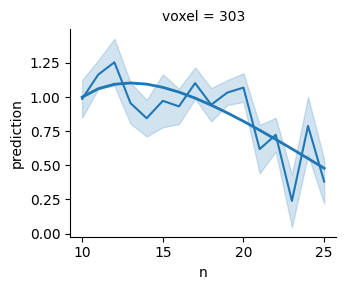

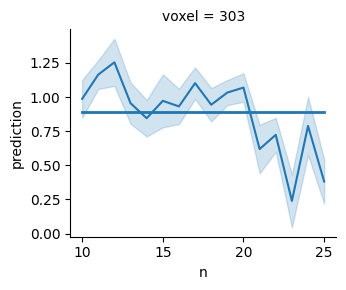

In [34]:
plot_prf_predictions('01', bids_folder=bids_folder, voxels=[303,], range_n='narrow')
plot_prf_predictions('01', bids_folder=bids_folder, voxels=[303,], range_n='narrow', gaussian=True)

In [52]:
df[mask][('lognormal',)].loc['01']

parameter                      mode                                       width                                 amplitude                                baseline  \
range_n                        wide     narrow       both      wide2       wide     narrow       both     wide2      wide    narrow      both     wide2      wide   
session smoothed   voxel                                                                                                                                            
both    smoothed   303     6.002522  12.981236  11.621823  42.080807  62.340797  60.298126  13.123940  3.979798  1.462872  5.552855  0.491395  0.000100 -0.359076   
                   367     0.868931  12.501335  10.356625  28.717173  61.088497  60.136692  13.822925  1.000000  1.626642  3.914020  0.390971  0.000100 -0.507130   
                   486    19.324503  12.911832  13.966791  19.314123   0.758055  60.144726   9.291607  0.747446  0.455764  2.122099  0.162843  0.432489  0.453958   
                   527    15.426988  19.205486  19.518347  28.717173   0.761183   2.309707   0.753075  1.000000  0.494128  0.215076  0.517397  0.000100  0.599008   
                   588    17.641480  19.229942  27.581142  28.717173  63.968790   2.069123   0.722444  1.000000  0.732602  0.207969  0.580544  0.000100 -0.498538   
        unsmoothed 219    38.992310  18.472998  38.990845  28.717173   0.544333   0.815481   0.548288  1.000000  0.549865  0.970604  0.561149  0.000100 -0.103022   
                   305     9.270807  12.085235   7.929293  11.795282  64.537900  58.885628  24.838385  2.290567  3.757507  9.134395  1.851090  0.957541 -1.327358   

parameter                                                     r2                                        cvr2                                
range_n                     narrow      both     wide2      wide    narrow      both         wide2      wide    narrow      both     wide2  
session smoothed   voxel                                                                                                                    
both    smoothed   303   -4.449759  0.582453  0.892780  0.050166  0.110665  0.065538  5.364418e-07 -0.033749  0.018553 -0.003247 -0.219133  
                   367   -3.102900  0.408751  0.640657  0.039792  0.090889  0.054550  3.576279e-07 -0.019835  0.013327 -0.003136 -0.115077  
                   486   -1.520109  0.420259  0.462910  0.018095  0.046848  0.019622  2.836353e-02 -0.102357  0.021762 -0.019899 -0.230986  
                   527    0.577877  0.596209  0.607895  0.012681  0.032683  0.016175  7.152557e-07 -0.129923  0.010743 -0.014121 -0.032514  
                   588    0.117494  0.156174  0.202502  0.017288  0.028330  0.007891  7.152557e-07 -0.109157  0.022012 -0.045768 -0.063373  
        unsmoothed 219   -0.174538 -0.114177 -0.133202  0.024562  0.031934  0.013311  6.556511e-07 -0.067512  0.010049 -0.038295 -0.153228  
                   305   -6.712466  0.669472  1.983647  0.079490  0.122796  0.084518  5.565202e-02  0.034910  0.060188  0.041411 -0.132295

In [54]:
from scipy import optimize

[10.06897582  1.20904566 -0.12288541]


(0.0, 1.35)

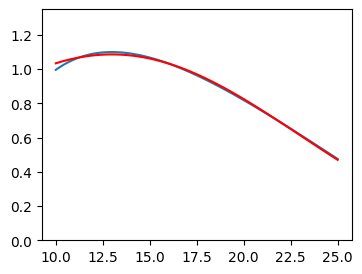

In [59]:
plt.figure(figsize=(4,3))
xxx = np.linspace(10,25,100)
model = LogGaussianPRF(parameterisation='mode_fwhm_natural')
yyy = model.predict(xxx, parameters=pd.DataFrame(data=[[12.98,60.29,5.55,-4.45],], columns=['mode', 'fwhm', 'amplitude', 'baseline']) ).values.flatten()
plt.plot(xxx, yyy)
#plt.plot(xxx, model.predict(xxx, parameters=pd.DataFrame(data=[[12.5,33,1,-0.7],], columns=['mode', 'fwhm', 'amplitude', 'baseline']) ) )
def objf(x):
    σ, a, b = x
    zzz = b + a*np.exp(-.5*((xxx-12.98)/σ)**2)
    r = ((zzz-yyy)**2).mean()
    #print(x,r)
    return r
res = optimize.minimize(objf, x0=[10, 1, -.7], bounds=[(0.,None), (0.,None), (None,None)])
_σ, _a, _b = res.x
print(res.x)
plt.plot(xxx, _b + _a*np.exp(-.5*((xxx-12.98)/_σ)**2), c='r')
#plt.plot(xxx, -.7 + 1*np.exp(-.5*((xxx-12.5)/10)**2), ls='--')
plt.ylim(0,1.35)

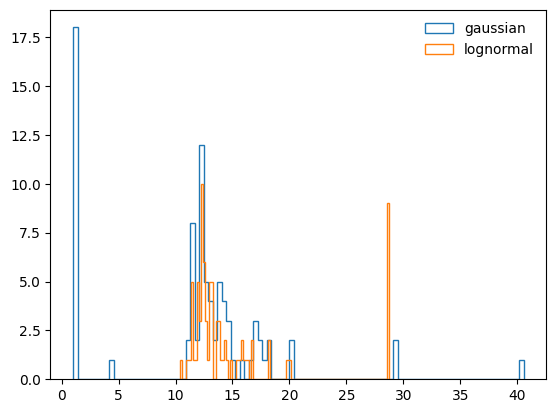

In [103]:
mask = (df[[('gaussian', 'cvr2', 'wide'), ('gaussian', 'cvr2', 'narrow')]].mean(1) > 0.01)
#mask &= (df[('gaussian', 'mode', 'narrow')] >= 10)
plt.hist( df[mask]['gaussian', 'mode', 'narrow'], histtype='step', bins=100, label='gaussian');
plt.hist( df[mask]['lognormal', 'mode', 'narrow'], histtype='step', bins=100, label='lognormal');
plt.legend();

In [25]:
for c in df['mode'].columns:

    mode = df[('mode', c)]
    fwhm = df[('fwhm', c)]

    df[('log_sigma', c)] = 1./(np.sqrt(2.*np.log(2.))) * np.arcsinh(fwhm/(mode*2.))
    df[('log(mode)', c)] = np.log(mode)

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/jq/_79_qpxx3vd0thkqqmw37l1c0000gn/T/ipykernel_25285/267291279.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tmp = df.stack('range_n')


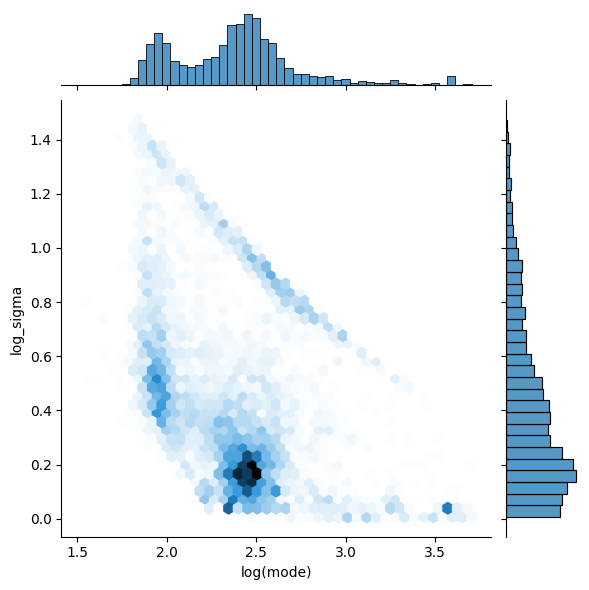

In [26]:
tmp = df.stack('range_n')
tmp = tmp[tmp.cvr2 > 0.01]
sns.jointplot(x='log(mode)', y='log_sigma', data=tmp.reset_index(), kind='hex')